In [1]:

from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE



загрузим и выведем информацию о тренировочных и тестовых данных 

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229292 entries, 0 to 229291
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    229292 non-null  int64  
 1   Gender                229292 non-null  object 
 2   Age                   229292 non-null  int64  
 3   Driving_License       229292 non-null  int64  
 4   Region_Code           229292 non-null  float64
 5   Previously_Insured    229292 non-null  int64  
 6   Vehicle_Age           229292 non-null  object 
 7   Vehicle_Damage        229292 non-null  object 
 8   Annual_Premium        229292 non-null  float64
 9   Policy_Sales_Channel  229292 non-null  float64
 10  Vintage               229292 non-null  int64  
 11  Response              229292 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 21.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152862 entries, 0 to 152861
Data columns (total 

Предварительная обработка данных 

In [3]:
ids = test_data["id"]
train_data.drop("id", axis=1, inplace=True)
test_data.drop("id", axis=1, inplace=True)
key = 'Response'
train_data

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,48,1,35.0,1,1-2 Year,No,24922.0,26.0,86,0
1,Male,58,1,28.0,0,1-2 Year,Yes,63541.0,26.0,57,0
2,Male,44,1,28.0,1,1-2 Year,No,30027.0,26.0,286,0
3,Female,22,1,8.0,0,< 1 Year,Yes,35039.0,152.0,180,0
4,Male,24,1,6.0,1,< 1 Year,No,24149.0,152.0,17,0
...,...,...,...,...,...,...,...,...,...,...,...
229287,Male,72,1,28.0,1,1-2 Year,No,39183.0,125.0,241,0
229288,Male,21,1,24.0,1,< 1 Year,No,2630.0,152.0,132,0
229289,Male,43,1,29.0,0,> 2 Years,Yes,2630.0,156.0,235,0
229290,Female,20,1,47.0,1,< 1 Year,Yes,30960.0,160.0,16,0


закодируем категориальные признаки

In [4]:

categorical_columns = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']


ohe = OneHotEncoder(sparse_output=False)


encoded_train_data = pd.DataFrame(ohe.fit_transform(train_data[categorical_columns]))
encoded_test_data = pd.DataFrame(ohe.transform(test_data[categorical_columns]))


encoded_train_data.columns = ohe.get_feature_names_out(categorical_columns)
encoded_test_data.columns = ohe.get_feature_names_out(categorical_columns)

train_data.drop(categorical_columns, axis=1, inplace=True)
test_data.drop(categorical_columns, axis=1, inplace=True)

train_data = pd.concat([train_data, encoded_train_data], axis=1)
test_data = pd.concat([test_data, encoded_test_data], axis=1)

print(train_data)


        Age  Driving_License  Region_Code  Previously_Insured  Annual_Premium  \
0        48                1         35.0                   1         24922.0   
1        58                1         28.0                   0         63541.0   
2        44                1         28.0                   1         30027.0   
3        22                1          8.0                   0         35039.0   
4        24                1          6.0                   1         24149.0   
...     ...              ...          ...                 ...             ...   
229287   72                1         28.0                   1         39183.0   
229288   21                1         24.0                   1          2630.0   
229289   43                1         29.0                   0          2630.0   
229290   20                1         47.0                   1         30960.0   
229291   20                1         32.0                   0         26610.0   

        Policy_Sales_Channe

теперь можно получить список для всех категориалных и числовых признаков. пусть числовыми признаками будут признаки с более чем пятью уникальными значениями

In [5]:
numeric = []
categorical = []
for name in train_data.columns:
    if train_data[name].nunique() > 5:
        numeric.append(name)
    else:
        categorical.append(name)
columns = numeric + categorical
categorical.remove(key)
print("Числовые:", numeric)
print("Категориальные:", categorical)

Числовые: ['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
Категориальные: ['Driving_License', 'Previously_Insured', 'Gender_Female', 'Gender_Male', 'Vehicle_Age_1-2 Year', 'Vehicle_Age_< 1 Year', 'Vehicle_Age_> 2 Years', 'Vehicle_Damage_No', 'Vehicle_Damage_Yes']


теперь проведем нормализацию числовых признаков

In [6]:
scaler = MinMaxScaler()
train_data[numeric] = scaler.fit_transform(train_data[numeric])
test_data[numeric] = scaler.fit_transform(test_data[numeric])
print('train data:\n', train_data.describe())
print('test data:\n', test_data.describe())


train data:
                  Age  Driving_License    Region_Code  Previously_Insured  \
count  229292.000000    229292.000000  229292.000000       229292.000000   
mean        0.285461         0.998138       0.508081            0.489062   
std         0.234333         0.043114       0.253682            0.499881   
min         0.000000         0.000000       0.000000            0.000000   
25%         0.076923         1.000000       0.288462            0.000000   
50%         0.246154         1.000000       0.538462            0.000000   
75%         0.446154         1.000000       0.673077            1.000000   
max         1.000000         1.000000       1.000000            1.000000   

       Annual_Premium  Policy_Sales_Channel        Vintage       Response  \
count   229292.000000         229292.000000  229292.000000  229292.000000   
mean         0.052276              0.684714       0.498943       0.164079   
std          0.031728              0.335236       0.289713       0.3703

отберем информативные признаки \n
для начала построим матрицы корреляции

<Axes: >

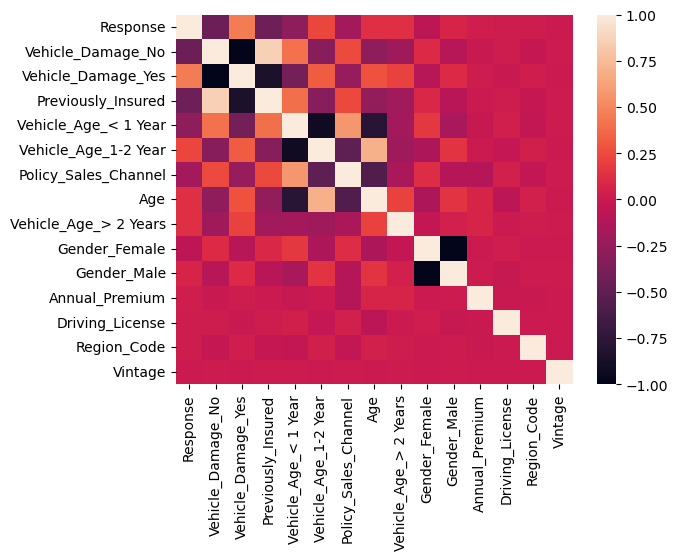

In [7]:
sorted_idx = train_data.corr()[key].abs().sort_values(ascending=False).index[:15]
corr_matrix = train_data[sorted_idx].corr()
sns.heatmap(corr_matrix)

Определим наиболее коррелирующие признаки

<Axes: >

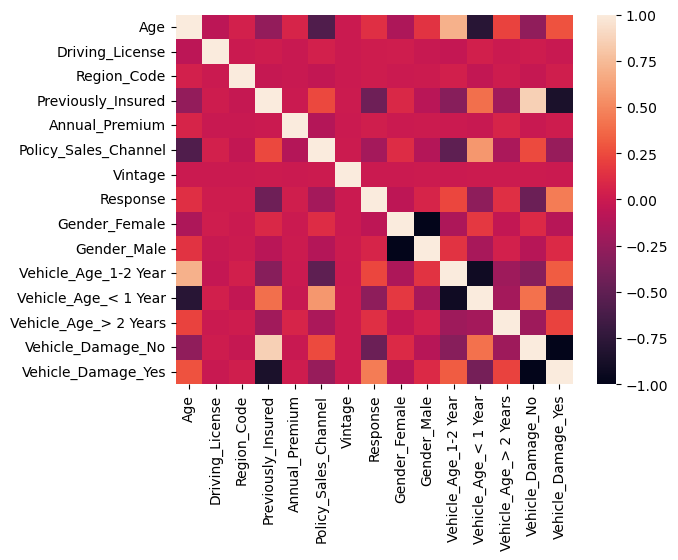

In [8]:
corr_matrix = train_data.corr()
threshold = 0.29
corr_region_mattrix = train_data.corrwith(train_data).abs()
weak_corr_features = set(corr_matrix[corr_region_mattrix  <= threshold].index)
train_data.drop(weak_corr_features, axis=1, inplace=True)
sns.heatmap(train_data.corr())  

оставим наименее кореллирующие друг с другом признаки

In [9]:
'''feature_select = train_data.drop(key, axis=1)
corr_series = feature_select.corr().abs().stack().sort_values()
corr_series = corr_series[~corr_series.duplicated()]
threshold = 0.75
drops = set([feature2 for (feature1, feature2), corr in corr_series.items() if
             corr > threshold and corr != 1])
train_data.drop(drops, axis=1, inplace=True)
sns.heatmap(train_data.corr(), annot=True)'''

'feature_select = train_data.drop(key, axis=1)\ncorr_series = feature_select.corr().abs().stack().sort_values()\ncorr_series = corr_series[~corr_series.duplicated()]\nthreshold = 0.75\ndrops = set([feature2 for (feature1, feature2), corr in corr_series.items() if\n             corr > threshold and corr != 1])\ntrain_data.drop(drops, axis=1, inplace=True)\nsns.heatmap(train_data.corr(), annot=True)'

In [10]:

x = train_data.drop([key], axis=1)
y = train_data[key]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [11]:
print(train_data)

             Age  Driving_License  Region_Code  Previously_Insured  \
0       0.430769                1     0.673077                   1   
1       0.584615                1     0.538462                   0   
2       0.369231                1     0.538462                   1   
3       0.030769                1     0.153846                   0   
4       0.061538                1     0.115385                   1   
...          ...              ...          ...                 ...   
229287  0.800000                1     0.538462                   1   
229288  0.015385                1     0.461538                   1   
229289  0.353846                1     0.557692                   0   
229290  0.000000                1     0.903846                   1   
229291  0.000000                1     0.615385                   0   

        Annual_Premium  Policy_Sales_Channel   Vintage  Response  \
0             0.041471              0.154321  0.262976         0   
1             0.113315 

In [12]:
print(test_data)

             Age  Driving_License  Region_Code  Previously_Insured  \
0       0.046154                1     0.788462                   1   
1       0.338462                1     0.538462                   1   
2       0.415385                1     0.538462                   1   
3       0.046154                1     0.788462                   1   
4       0.338462                1     0.788462                   0   
...          ...              ...          ...                 ...   
152857  0.338462                1     0.673077                   1   
152858  0.046154                1     0.615385                   1   
152859  0.169231                1     0.557692                   1   
152860  0.030769                1     0.557692                   1   
152861  0.415385                1     0.250000                   0   

        Annual_Premium  Policy_Sales_Channel   Vintage  Gender_Female  \
0             0.049722              0.932099  0.238754            0.0   
1            

теперь построим модель

In [13]:



pca = PCA(n_components=9)  
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
smote = SMOTE()
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
x_test_resampled, y_test_resampled = smote.fit_resample(x_test, y_test)

In [14]:


models = {
    'Логистическая Регрессия': LogisticRegression(solver='liblinear'),
    'Метод Ближайших Соседей': KNeighborsClassifier(),
    'Наивный Байесовский Классификатор': GaussianNB(),
    'Линейный Дискриминантный Анализ': LinearDiscriminantAnalysis(),
    'Квадратичный Дискриминантный Анализ': QuadraticDiscriminantAnalysis(),
    'Машина Опорных Векторов': SVC()
}

params = {
    'Логистическая Регрессия': {"max_iter": [100],
                                 "solver": ['sag', 'saga', 'newton-cg'],
                                 "n_jobs": [-1]},
    'Метод Ближайших Соседей': {"n_neighbors": list(range(3, 7)),
                                 "weights": ["uniform", "distance"],
                                 "p": [1, 2, 3, 4]},  
    'Наивный Байесовский Классификатор': {},
    'Линейный Дискриминантный Анализ': {"solver":  ["svd", 'lsqr', "eigen"]},
    'Квадратичный Дискриминантный Анализ': {"reg_param": np.linspace(0, 1, num=101)},
    'Машина Опорных Векторов': {"kernel": ['poly'],
                                'probability': [True],
                                 "class_weight": ["balanced"],
                                 "max_iter": [-1]}
}
 
best_models = {}
for name, model in models.items():
    random_search = GridSearchCV(model, params[name], cv=5, scoring='roc_auc', n_jobs=-1)
    random_search.fit(x_train_resampled, y_train_resampled)
    best_model = random_search.best_estimator_
    best_models[name] = best_model


   

In [ ]:
print(best_models)
results = {}

for name, model in best_models.items():
    model.fit(x_train_resampled, y_train_resampled) 
    y_pred = model.predict(x_test_resampled)
    score = roc_auc_score(y_test_resampled, y_pred)
    results[name] = score  
    if name == 'Машина Опорных Векторов':
        model.fit(x_train_resampled, y_train_resampled) 
        y_pred = model.predict_proba(x_test_resampled)[:,1]
        score = roc_auc_score(y_test_resampled, y_pred)
        results[name] = score  
print(results)

{'Логистическая Регрессия': LogisticRegression(n_jobs=-1, solver='sag'), 'Метод Ближайших Соседей': KNeighborsClassifier(n_neighbors=6, p=1, weights='distance'), 'Наивный Байесовский Классификатор': GaussianNB(), 'Линейный Дискриминантный Анализ': LinearDiscriminantAnalysis(), 'Квадратичный Дискриминантный Анализ': QuadraticDiscriminantAnalysis(), 'Машина Опорных Векторов': SVC(class_weight='balanced', kernel='poly', probability=True)}
{'Логистическая Регрессия': 0.8110588235294117, 'Метод Ближайших Соседей': 0.7684705882352941, 'Наивный Байесовский Классификатор': 0.8126971677559912, 'Линейный Дискриминантный Анализ': 0.812575163398693, 'Квадратичный Дискриминантный Анализ': 0.814649237472767, 'Машина Опорных Векторов': 0.8762383252025573}


In [ ]:
best_model_name = max(results, key=results.get)
best_model = best_models[best_model_name]
print("Лучшая модель:", best_model_name)


Лучшая модель: Машина Опорных Векторов


In [ ]:
#test_data_pca = pca.fit_transform(test_data)
#test_data_resampled, _= smote.fit_resample(test_data_pca, y)

ValueError: Found input variables with inconsistent numbers of samples: [152862, 229292]

In [ ]:
# Предсказание на тестовых данных
test_ids = test_data["id"]
y_pred = best_model.predict(test_data)

# Создание DataFrame для submission
submission = pd.DataFrame({'id': ids, 'Response': y_pred})

# Сохранение DataFrame в CSV файл
submission.to_csv('submission.csv', index=False)

print("Файл submission.csv сохранен.")

Файл submission.csv сохранен.
